## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**OCO-2 MIP Top-down CO2 Budgets**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/oco2-mip-co2budget-yeargrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1° x 1°
- **Temporal extent**: 2015 – 2020
- **Temporal resolution**: Annual
- **Unit**: Grams of carbon dioxide per square meter per year
- **Utility**: Climate Research

For more, visit the [OCO-2 MIP Top-down CO2 Budgets](https://earth.gov/ghgcenter/data-catalog/oco2-mip-co2budget-yeargrid-v1) data overview page.  

## Approach

1. Read in National CO2 Budgets using Pandas
2. Sub-select the data structure using Pandas
3. Visualize the CO2 budgets for a country
4. Investigate uncertainties and metrics for understanding the dataset

## About the Data

This tutorial guides a user to further explore data from the Carbon Observatory (OCO-2) modeling intercomparison project (MIP). It is designed for those with more understanding of the science and is therefore labeled as intermediate level.

The code is used to estimate the annual net terrestrial carbon stock loss (ΔC<sub>loss</sub>) and net carbon exchange (NCE) for a given country using the “top-down” NCE outputs from the Carbon Observatory (OCO-2) modeling intercomparison project (MIP). Several standardized experiments are studied in this notebook based on the OCO-2 MIP dataset including flux estimates from in situ CO₂ measurements (IS), flux estimates from OCO-2 land CO₂ data (LNLG), combined in situ and OCO-2 land CO₂ data (LNLGIS), and combined in situ and OCO-2 land and ocean CO₂ data (LNLGOGIS). Estimates and uncertainties associated with fossil fuels, riverine fluxes, and wood and crop fluxes are also graphed along with the ΔC<sub>loss</sub> and NCE variables.

For more information about this data collection, please visit the [OCO-2 MIP Top-Down CO2 Budgets](https://earth.gov/ghgcenter/data-catalog/oco2-mip-co2budget-yeargrid-v1) data overview page.

For more information regarding this dataset, please visit the [U.S. Greenhouse Gas Center](https://earth.gov/ghgcenter).

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:


%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet


## Import required modules
First we will need to import the relevant python modules:

In [1]:
import pandas as pd # for manipulating csv dataset
import numpy as np
import matplotlib.pyplot as plt # make plots
from scipy.stats import norm # We will use this for understanding significance

## Read the CO2 National budget dataset

Now we will read in the csv dataset from https://ceos.org/gst/carbon-dioxide.html

In [2]:
url ='https://ceos.org/gst/files/pilot_topdown_CO2_Budget_countries_v1.csv'
df_all = pd.read_csv(url, skiprows=52)

## Sub-select a single top-down dataset (experiment)

To simplify the analysis, let's subselect the results for a single experiment. The experiments are:
- IS: estimates fluxes from in situ CO2 measurements
- LNLG: estimates fluxes from OCO-2 land CO2 data
- LNLGIS: combines in situ and OCO-2 land CO2 data
- LNLGOGIS: combines in situ and OCO-2 land and ocean CO2 data

We would like to use the experiment that uses the most high-quality CO2 data. There are some concerns about small residual biases in OCO-2 ocean data (Byrne et al., 2023), so let's use the LNLGIS experiment.

In [3]:
# Choose one experiment from the list ['IS', 'LNLG', 'LNLGIS', 'LNLGOGIS']
experiment = 'LNLGIS'

# Subset of columns for a given experiment
if experiment == 'IS':
    df = df_all.drop(df_all.columns[[4,5,6,7,8,9,12,13,14,15,16,17,20,21,22,23,24,25,34,35,36]], axis=1)
if experiment == 'LNLG':
    df = df_all.drop(df_all.columns[[2,3,6,7,8,9,10,11,14,15,16,17,18,19,22,23,24,25,33,35,36]], axis=1)
if experiment == 'LNLGIS':
    df = df_all.drop(df_all.columns[[2,3,4,5,8,9,10,11,12,13,16,17,18,19,20,21,24,25,33,34,36]], axis=1)
if experiment == 'LNLGOGIS':
    df = df_all.drop(df_all.columns[[2,3,4,5,6,7,10,11,12,13,14,15,18,19,20,21,22,23,33,34,35]], axis=1)

# We can now look at the colums of data
df.head()

,Alpha 3 Code,Year,LNLGIS dC_loss (TgCO2),LNLGIS dC_loss unc (TgCO2),LNLGIS NBE (TgCO2),LNLGIS NBE unc (TgCO2),LNLGIS NCE (TgCO2),LNLGIS NCE unc (TgCO2),Rivers (TgCO2),River unc (TgCO2),Wood+Crop (TgCO2),Wood+Crop unc (TgCO2),FF (TgCO2),FF unc (TgCO2),Z-statistic,FUR LNLGIS
0,AFG,2015,39.3407,153.746,40.9643,153.746,60.3537,153.744,-2.43286,1.69832,4.05648,1.21694,19.3894,0.797698,0.37,0.19
1,AFG,2016,50.6167,175.454,52.5114,175.454,73.0333,175.452,-2.16185,2.24033,4.05648,1.21694,20.5220,0.678080,0.31,0.19
2,AFG,2017,54.5096,179.794,56.4726,179.794,77.5355,179.793,-2.09349,2.37705,4.05648,1.21694,21.0629,0.695856,0.47,0.19
3,AFG,2018,116.4260,243.057,118.4610,243.057,143.9580,243.056,-2.02199,2.52005,4.05648,1.21694,25.4974,0.695856,0.39,0.19
4,AFG,2019,64.0162,181.516,66.0388,181.516,93.8974,181.514,-2.03383,2.49637,4.05648,1.21694,27.8585,0.797698,0.49,0.19


## Sub-select a single country

Let's further filter the dataset to look at a specific country. Choose a country by entering the alpha code in the country_name variable below

In [4]:
# Choose a country
country_name = 'USA' 

# We can sub-select the data for the country
country_data = df[df['Alpha 3 Code'] == country_name]

# Now we can look at the data for a specific experiment and country
country_data.head()

,Alpha 3 Code,Year,LNLGIS dC_loss (TgCO2),LNLGIS dC_loss unc (TgCO2),LNLGIS NBE (TgCO2),LNLGIS NBE unc (TgCO2),LNLGIS NCE (TgCO2),LNLGIS NCE unc (TgCO2),Rivers (TgCO2),River unc (TgCO2),Wood+Crop (TgCO2),Wood+Crop unc (TgCO2),FF (TgCO2),FF unc (TgCO2),Z-statistic,FUR LNLGIS
1232,USA,2015,-1031.83,721.213,-1346.46,721.213,4017.31,713.897,-165.430,71.7453,-149.196,-44.7589,5363.77,102.4670,-0.81,0.91
1233,USA,2016,-1419.92,399.738,-1743.80,399.738,3529.45,387.079,-174.684,53.2375,-149.196,-44.7589,5273.24,99.8012,0.04,0.91
1234,USA,2017,-1375.12,1034.010,-1696.63,1034.010,3515.14,1029.250,-172.308,57.9894,-149.196,-44.7589,5211.76,99.0981,0.67,0.91
1235,USA,2018,-1018.89,784.463,-1333.83,784.463,4036.65,778.179,-165.747,71.1117,-149.196,-44.7589,5370.48,99.0981,-0.20,0.91
1236,USA,2019,-1161.41,718.054,-1504.61,718.054,3728.95,710.705,-194.005,14.5948,-149.196,-44.7589,5233.56,102.4670,-0.38,0.91


#This dataset contains fluxes over a five year period, 2015-2020. 

Let's look at a plot of the annual net terrestrial carbon stock loss (ΔC<sub>loss</sub>) for each year.

(-0.30000000000000004, 6.3)

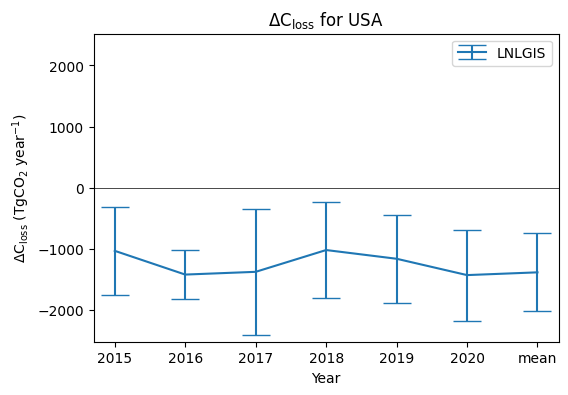

In [5]:
# Make plot
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.errorbar(country_data['Year'],country_data[experiment+' dC_loss (TgCO2)'],
                    yerr=country_data[experiment+' dC_loss unc (TgCO2)'],label=experiment,capsize=10)
ax1.legend(loc='upper right')
ax1.set_ylabel('$\Delta$C$_\mathrm{loss}$ (TgCO$_2$ year$^{-1}$)')
ax1.set_xlabel('Year')
ax1.set_title('$\Delta$C$_\mathrm{loss}$ for '+country_name)
ymin, ymax = ax1.get_ylim()
max_abs_y = max(abs(ymin), abs(ymax))
ax1.set_ylim([-max_abs_y, max_abs_y])
xmin, xmax = ax1.get_xlim()
ax1.plot([xmin,xmax],[0,0],'k',linewidth=0.5)
ax1.set_xlim([xmin, xmax])

Next, we can look at the full carbon budget for a given year.

The code below creates a plot similar to Fig 13 of Byrne et al. (2023). Each of the bars on the left side of the dashed vertical line (Fossil fuel emissions, lateral C transport by rivers, lateral C transport in crop and wood products, and the net terrestrial carbon stock loss combined to give the net carbon exchange (net surface-atmosphere CO2 flux) shown on the right.

1238   -44.7589
Name: Wood+Crop unc (TgCO2), dtype: float64


Text(0, 0.5, 'CO$_2$ Flux (TgCO$_2$ year$^{-1}$)')

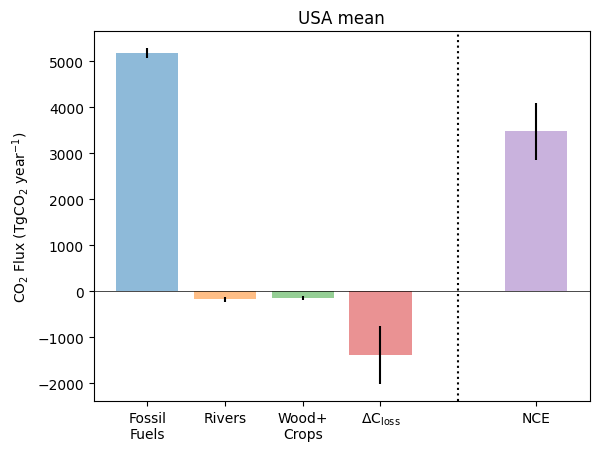

In [6]:
# Pick a specifc year (or mean year)
year='mean'

# Make plot
country_data_mean = country_data[country_data['Year'] == year]
a=country_data_mean['Wood+Crop (TgCO2)']
b=country_data_mean['Wood+Crop unc (TgCO2)']
print(b)
#
plt.bar(1, country_data_mean['FF (TgCO2)'], yerr=country_data_mean['FF unc (TgCO2)'], label='FF', alpha=0.5)
plt.bar(2, country_data_mean['Rivers (TgCO2)'], yerr=country_data_mean['River unc (TgCO2)'], label='Rivers', alpha=0.5)
plt.bar(3, country_data_mean['Wood+Crop (TgCO2)'], yerr=abs(country_data_mean['Wood+Crop unc (TgCO2)']), label='WoodCrop', alpha=0.5)
plt.bar(4, country_data_mean[experiment+' dC_loss (TgCO2)'], yerr=country_data_mean['LNLGIS dC_loss unc (TgCO2)'], label='dC', alpha=0.5)
plt.bar(6, country_data_mean[experiment+' NCE (TgCO2)'], yerr=country_data_mean['LNLGIS NCE unc (TgCO2)'], label='NCE', alpha=0.5)
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.plot([5,5],[ymin,ymax],'k:')
xmin, xmax = ax.get_xlim()
plt.plot([xmin,xmax],[0,0],'k',linewidth=0.5)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
#
plt.xticks([1,2,3,4,6], ['Fossil\nFuels','Rivers','Wood+\nCrops','$\mathrm{\Delta C _{loss}}$','NCE'])
plt.title(country_name+' '+year)
plt.ylabel('CO$_2$ Flux (TgCO$_2$ year$^{-1}$)')

Uncertainty is an important consideration when analyzing the flux estimates provided by Byrne et al. (2023).

Each flux estimate is provided with an error estimate representing the standard deviation, and assuming the errors are well prepresented by a normal distribution. This probability dirtribution provided by this uncertainty can be visualized below. We can further quantify the 

Text(0.5, 0, 'dC_loss (TgCO$_2$ year$^{-1}$)')

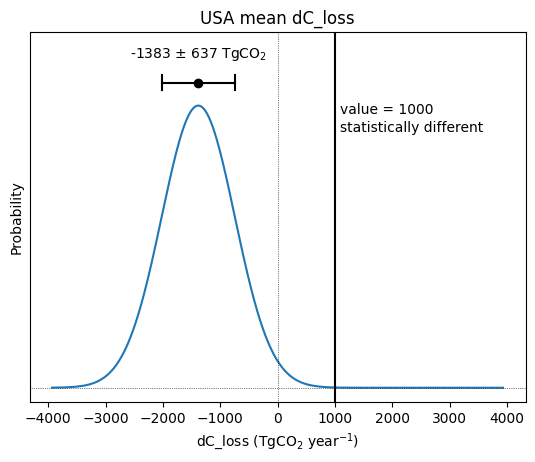

In [7]:

# Select NCE, NBE or dC_loss
quantity = 'dC_loss'

# Value for comparison
comparison_value = 1000 # TgCO2/year


MIP_mean = country_data_mean[experiment+' '+quantity+' (TgCO2)'].item()
MIP_std = country_data_mean[experiment+' '+quantity+' unc (TgCO2)'].item()

# Perform t-test
t_value = abs(MIP_mean - comparison_value)/(MIP_std / np.sqrt(11))
crtical_value = 2.23 # use p=0.05 significance
if t_value > crtical_value:
    ttest = 'statistically different'
if t_value < crtical_value:
    ttest = 'not statistically\ndifferent'

# Make plot
xbounds = abs(MIP_mean)+MIP_std*4
if abs(crtical_value) > xbounds:
    xbounds = abs(crtical_value)
x_axis = np.arange(-1.*xbounds, xbounds, 1) 
plt.plot(x_axis, norm.pdf(x_axis, MIP_mean, MIP_std)) 
ax = plt.gca()
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
plt.plot([0,0],[ymin,ymax*1.2],'k:',linewidth=0.5)
plt.plot([xmin,xmax],[0,0],'k:',linewidth=0.5)
plt.plot([comparison_value,comparison_value],[ymin,ymax*1.2],'k')
plt.text(comparison_value+(xmax-xmin)*0.01,ymax*0.96,'value = '+str(comparison_value),ha='left',va='top')
plt.text(comparison_value+(xmax-xmin)*0.01,ymax*0.9,ttest,ha='left',va='top')
plt.ylim([ymin,ymax*1.2])
plt.xlim([xmin,xmax])
plt.plot(MIP_mean,ymax*1.03,'ko')
plt.plot([MIP_mean-MIP_std,
         MIP_mean+MIP_std],
         [ymax*1.03,ymax*1.03],'k')
plt.plot([MIP_mean-MIP_std,
         MIP_mean-MIP_std],
         [ymax*1.005,ymax*1.055],'k')
plt.plot([MIP_mean+MIP_std,
         MIP_mean+MIP_std],
         [ymax*1.005,ymax*1.055],'k')
plt.text(MIP_mean,ymax*1.115,
         str(round(MIP_mean))+' $\pm$ '+
         str(round(MIP_std))+' TgCO$_2$',ha='center')
plt.title(country_name+' '+year+' '+quantity+'')
plt.yticks([])
plt.ylabel('Probability')
plt.xlabel(quantity+' (TgCO$_2$ year$^{-1}$)')

Finally, we will examine two metrics that are useful for understanding the confidence in the top-down results:

- Z-statistic: metric of agreement in NCE estimates across the experiments that assimilate different CO2 datasets. Experiments are considered significantly different if the magnitude exceeds 1.96

- Fractional Uncertainty Reduction (FUR): metric of how strongly the assimilated CO2 data on reduce NCE uncertainties. Values range from 0 to 1, with 0 meaning zero error reduction and 1 meaning complete error reduction

Here we will add a plot of the Z-statistic for each year, and add the FUR value for the country.

Text(-0.18000000000000005, 2.6, 'Fractional error reduction: 0.91')

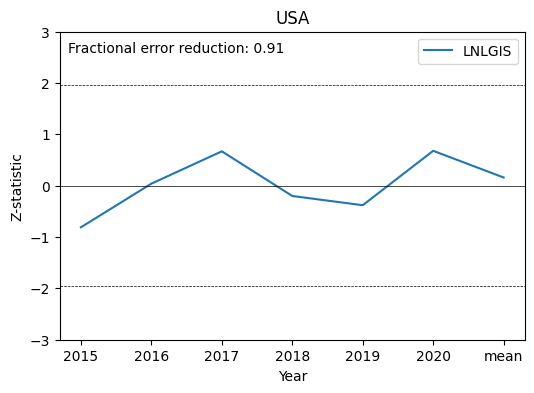

In [8]:
# Make plot
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.plot(country_data['Year'],country_data['Z-statistic'],label=experiment)
ax1.legend(loc='upper right')
ax1.set_ylabel('Z-statistic')
ax1.set_xlabel('Year')
ax1.set_title(country_name)
ymin, ymax = ax1.get_ylim()
max_abs_y = max(abs(ymin), abs(ymax))
ax1.set_ylim([-3, 3])
xmin, xmax = ax1.get_xlim()
ax1.plot([xmin,xmax],[0,0],'k',linewidth=0.5)
ax1.plot([xmin,xmax],[-1.96,-1.96],'k--',linewidth=0.5)
ax1.plot([xmin,xmax],[1.96,1.96],'k--',linewidth=0.5)
ax1.set_xlim([xmin, xmax])
ax1.text(xmin+0.12,2.6,'Fractional error reduction: '+str(country_data['FUR '+experiment].iloc[1]))